In [2]:
%load_ext autoreload
%autoreload 2
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
import tqdm
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import socceraction.atomic.features as fs
#import socceraction.atomic.labels as lab

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
## Configure file and folder names
datafolder = "../data/private"
spadl_h5 = os.path.join(datafolder,"epl-spadl-statsbomb.h5")

In [4]:
games = pd.read_hdf(spadl_h5,"games")
games = games[(games.competition_name == "Premier League")
             & (games.season_name == "2018/2019")]
print("nb of games:", len(games))

actiontypes = pd.read_hdf(spadl_h5, "atomic_actiontypes")
bodyparts = pd.read_hdf(spadl_h5, "bodyparts")

nb of games: 380


In [5]:
with pd.HDFStore(spadl_h5) as spadlstore:
    actions = []
    for game in tqdm.tqdm(games.itertuples()):
        a = spadlstore[f"atomic_actions/game_{game.game_id}"]
        [a] = fs.play_left_to_right([a],game.home_team_id)
        actions.append(a)
    actions = pd.concat(actions)
    actions = actions.merge(spadlstore["atomic_actiontypes"],how="left")
actions[:5]

380it [00:16, 22.70it/s]


,game_id,period_id,action_id,time_seconds,timestamp,team_id,player_id,x,y,dx,dy,type_id,bodypart_id,type_name
0,14562.0,1.0,0,1.0,00:00:01.344,58.0,9923.0,52.058824,34.430380,-10.588235,-0.000000,0,0,pass
1,14562.0,1.0,1,1.5,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,23,0,receival
2,14562.0,1.0,2,2.0,00:00:02.117,58.0,9917.0,41.470588,34.430380,-0.000000,-0.000000,21,0,dribble
3,14562.0,1.0,3,2.0,00:00:02.969,58.0,9917.0,41.470588,34.430380,-15.882353,-14.632911,0,0,pass
4,14562.0,1.0,4,3.0,00:00:04.338,58.0,9924.0,25.588235,19.797468,-0.000000,-0.000000,23,0,receival


In [6]:
from scipy.spatial import Delaunay
import networkx as nx

def color_clusters(clusters,colors):
    tri = Delaunay(clusters)
    edges = set()
    for s in tri.simplices:
        [a,b,c] = s
        es = set([frozenset([a,b]),frozenset([b,c]),frozenset([c,a])])
        edges = edges | es
    G = nx.Graph()
    for e in edges:
        [i,j] = list(e)
        G.add_edge(i, j)
    
    if len(G.nodes) > 0:
        r_ = max([G.degree(node) for node in G.nodes])
    else:
        r_ = 0
    if r_ > len(colors)-1:
        colorassign = nx.algorithms.coloring.greedy_color(G)
    else:
        colorassign = nx.algorithms.coloring.equitable_color(G,len(colors))
    colorvector = [0] * len(clusters)
    for k,v in colorassign.items():
        colorvector[k] = int(v)
    return [colors[i] for i in colorvector]

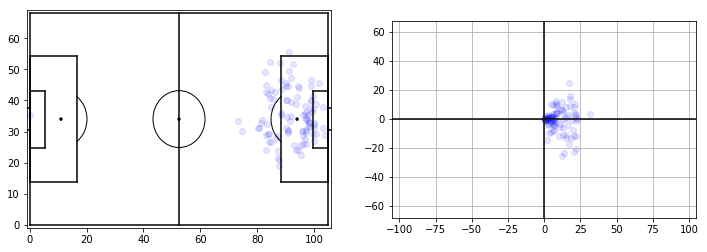

In [8]:
import matplotsoccer as mps
import matplotlib.pyplot as plt

a = actions[actions.type_name == "shot"][:100]


def plot_deltas(x,y,dx,dy,color):
    fig,axs = plt.subplots(1,2)
    fig.set_size_inches((12,4))
    axs[0].scatter(x,y,color=color,alpha=0.1)
    axs[1].scatter(dx,dy,color=color,alpha=0.1)
    mps.field(ax=axs[0],show=False)
    plt.axis("on")
    plt.axis("scaled")
    axs[1].axvline(0,color="black")
    axs[1].axhline(0,color="black")
    axs[1].grid()
    axs[0].set_xlim(-1,105+1)
    axs[0].set_ylim(-1,68+1)
    #axs[1].set_xlim(-1.1,1.1)
    #axs[1].set_ylim(-1.1,1.1)
    axs[1].set_xlim(-105,105)
    axs[1].set_ylim(-68,68)
    plt.show()
plot_deltas(a.x,a.y,a.dx,a.dy,color="blue")

In [15]:
import sklearn.mixture as mix
col = ["x","y","dx","dy"]

models = {}
for k, df in actions[:100000].fillna(0).groupby("type_name"):
    if len(df) > 20:
        model = {}
        model["df"] = df[col]
        model["base"] = mix.GaussianMixture(1).fit(model["df"])
        model["base_bic"] = model["base"].bic(model["df"])
        model["cand"] = mix.GaussianMixture(2).fit(model["df"])
        model["cand_bic"] = model["cand"].bic(model["df"])
    models[k] = model

models

{'bad_touch': {'df':                 x          y   dx   dy
  16      96.176471  65.417722 -0.0 -0.0
  71      83.823529  55.949367 -0.0 -0.0
  139     59.117647  35.291139  0.0  0.0
  262    103.235294  49.924051  0.0  0.0
  448     96.176471  11.189873 -0.0 -0.0
  454     47.647059  49.924051  0.0  0.0
  483     71.470588  66.278481 -0.0 -0.0
  490     69.705882  65.417722 -0.0 -0.0
  601     84.705882  43.898734 -0.0 -0.0
  628     60.000000  65.417722 -0.0 -0.0
  635     60.882353   2.582278  0.0  0.0
  893     98.823529  32.708861  0.0  0.0
  923     45.882353  24.101266  0.0  0.0
  1032    55.588235  44.759494  0.0  0.0
  1170    68.823529  12.050633 -0.0 -0.0
  1248    59.117647  37.873418 -0.0 -0.0
  1365    83.823529  21.518987  0.0  0.0
  1497    54.705882  13.772152  0.0  0.0
  1724    75.000000   1.721519  0.0  0.0
  1733    87.352941  49.924051 -0.0 -0.0
  2004    69.705882  49.924051 -0.0 -0.0
  2063    67.941176  22.379747 -0.0 -0.0
  2151    60.882353  65.417722 -0.0 -0

In [12]:
set(actions.type_name)
colors = ["#e41a1c",
"#377eb8",
"#4daf4a",
"#984ea3",
"#ff7f00",
"#ffff33",
"#a65628",
"#f781bf",
"#999999",
         ]
clustercolors = colors * 10
atoh = fs.feature_column_names([fs.actiontype_onehot],1)
atoh

['type_pass_a0',
 'type_cross_a0',
 'type_throw_in_a0',
 'type_freekick_crossed_a0',
 'type_freekick_short_a0',
 'type_corner_crossed_a0',
 'type_corner_short_a0',
 'type_take_on_a0',
 'type_foul_a0',
 'type_tackle_a0',
 'type_interception_a0',
 'type_shot_a0',
 'type_shot_penalty_a0',
 'type_shot_freekick_a0',
 'type_keeper_save_a0',
 'type_keeper_claim_a0',
 'type_keeper_punch_a0',
 'type_keeper_pick_up_a0',
 'type_clearance_a0',
 'type_bad_touch_a0',
 'type_non_action_a0',
 'type_dribble_a0',
 'type_goalkick_a0',
 'type_receival_a0',
 'type_out_a0',
 'type_offside_a0',
 'type_goal_a0',
 'type_owngoal_a0',
 'type_yellow_card_a0',
 'type_red_card_a0']

In [37]:
actions.type_name.value_counts(True)
varxy = actions.groupby("type_name")[["x","y"]].var().reset_index()
actions["count"] = 1
atcnt = actions.groupby("type_name")["count"].count().reset_index()
atcnt.merge(varxy)

,type_name,count,x,y
0,bad_touch,9472,534.257857,455.668058
1,clearance,18135,166.109950,174.622941
2,corner_crossed,3128,0.012196,1156.016064
3,corner_short,754,0.000000,1156.362419
4,cross,8284,63.861126,569.783320
5,dribble,332431,583.727206,409.534980
6,foul,8924,553.926228,414.949383
7,freekick_crossed,4428,791.884475,412.487971
8,freekick_short,4060,364.977735,392.632053
9,goal,1040,0.232600,6.167996


100000
Initialization 0
  Iteration 10	 time lapse 57.82250s	 ll change 0.11421
  Iteration 20	 time lapse 50.02293s	 ll change 0.00032
Initialization converged: True	 time lapse 107.84572s	 ll 167.07470


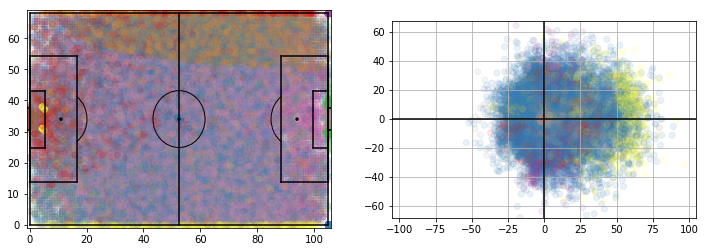

['x', 'y', 'dx', 'type_throw_in_a0']


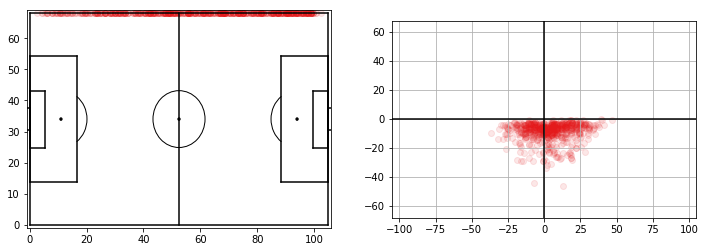

['x', 'y', 'type_foul_a0']


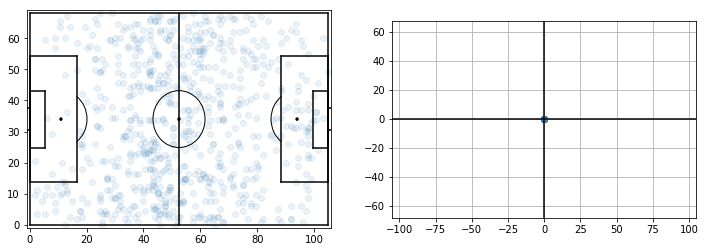

['x', 'y', 'type_tackle_a0']


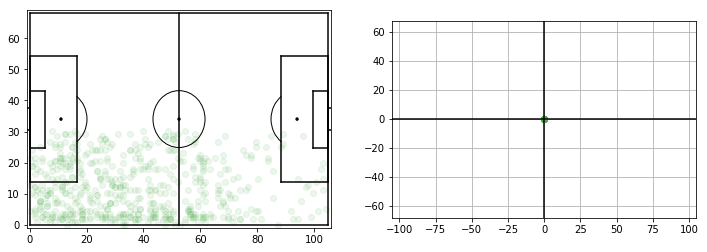

['x', 'y', 'type_offside_a0']


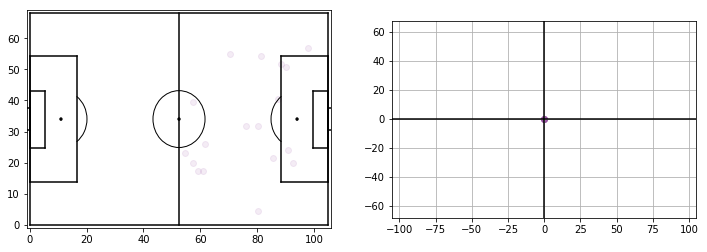

['x', 'y', 'type_receival_a0']


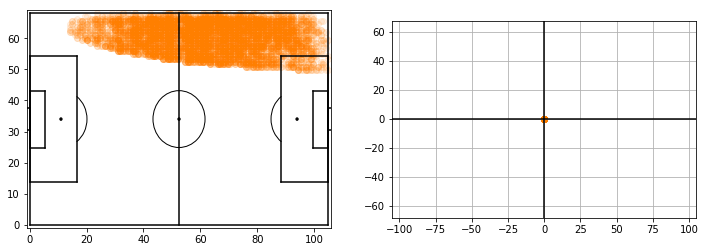

['x', 'y', 'dx', 'dy', 'type_freekick_crossed_a0', 'type_goalkick_a0']


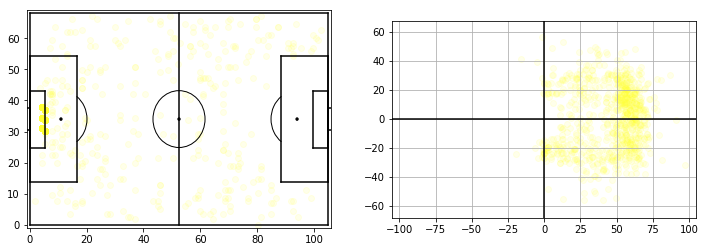

['x', 'y', 'type_keeper_save_a0', 'type_keeper_claim_a0', 'type_keeper_punch_a0', 'type_owngoal_a0']


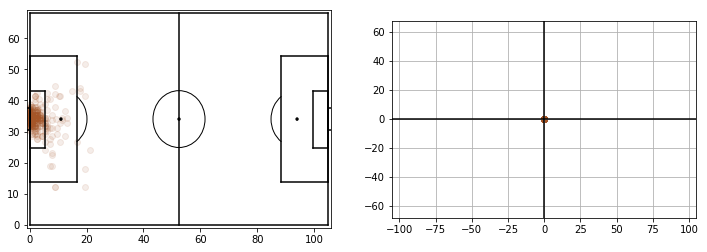

['x', 'y', 'type_interception_a0']


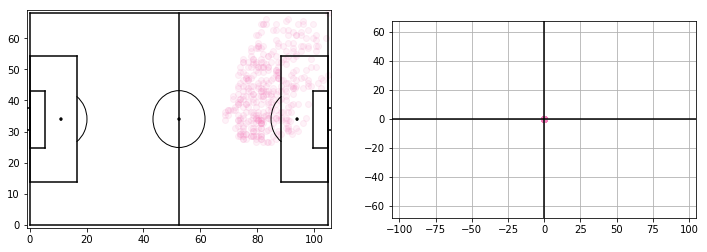

['x', 'y', 'type_interception_a0']


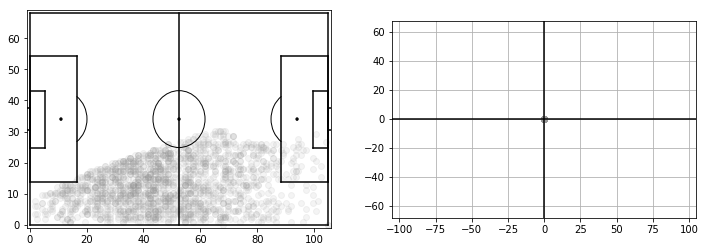

['x', 'y', 'type_tackle_a0']


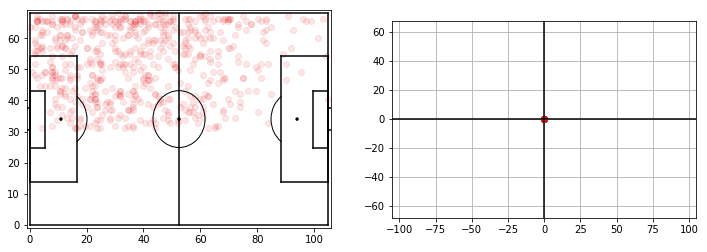

['x', 'dy', 'type_corner_crossed_a0', 'type_corner_short_a0']


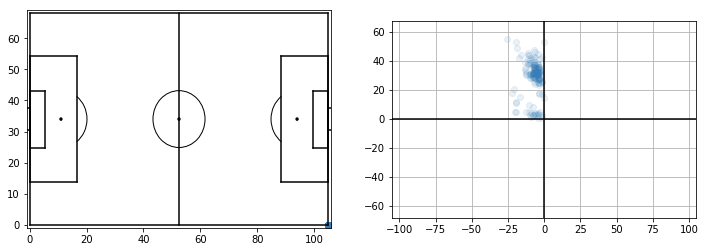

['x', 'y', 'type_out_a0', 'type_yellow_card_a0']


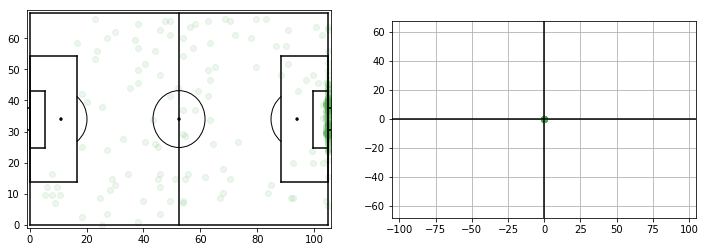

['x', 'y', 'dx', 'dy', 'type_cross_a0', 'type_shot_freekick_a0']


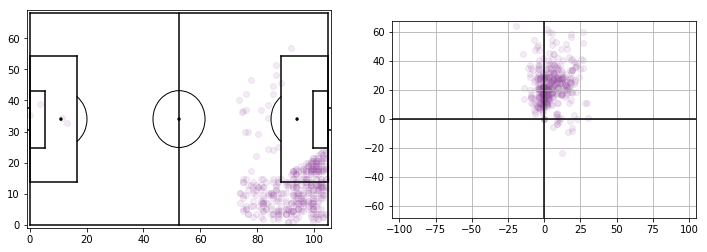

['x', 'y', 'type_bad_touch_a0']


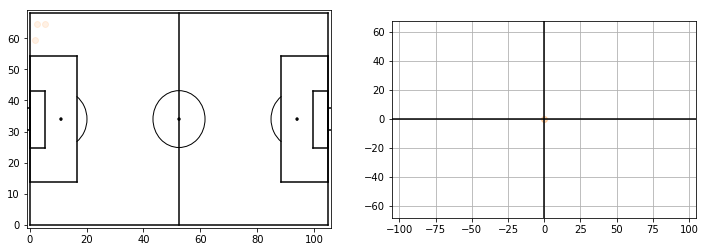

['x', 'y', 'type_out_a0']


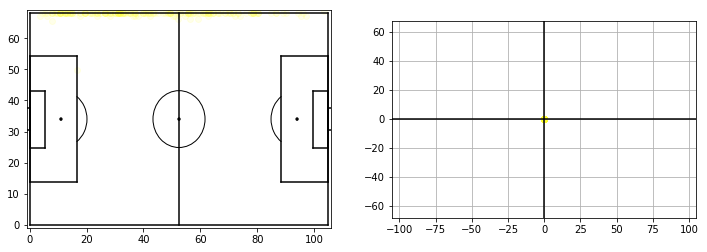

['x', 'y', 'type_bad_touch_a0']


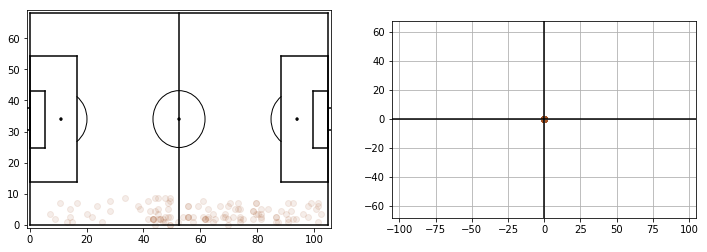

['x', 'y', 'dx', 'dy', 'type_shot_penalty_a0', 'type_goal_a0']


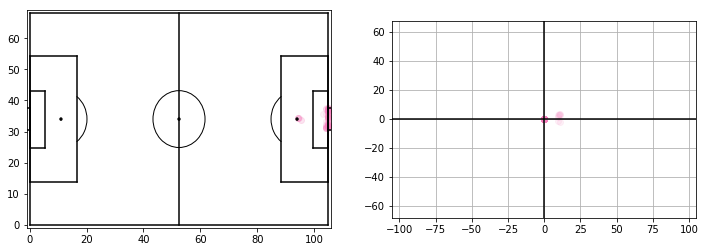

['x', 'y', 'type_out_a0']


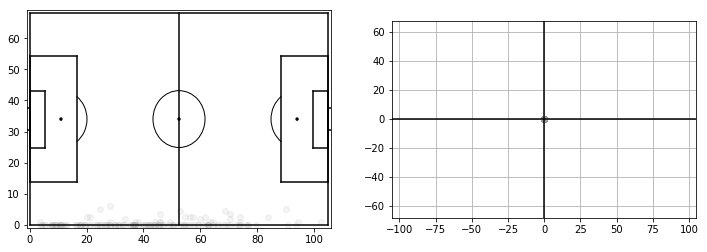

['x', 'y', 'type_interception_a0']


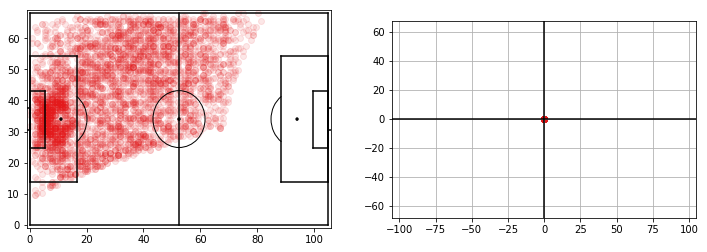

['x', 'y', 'dx', 'dy', 'type_pass_a0', 'type_freekick_short_a0']


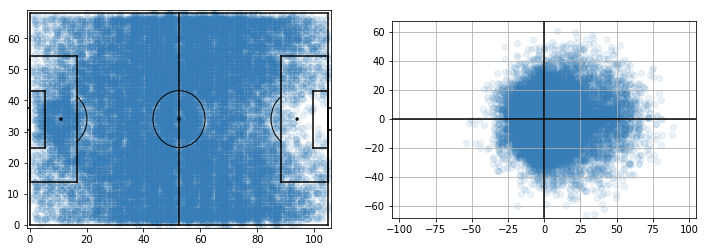

['x', 'y', 'type_bad_touch_a0']


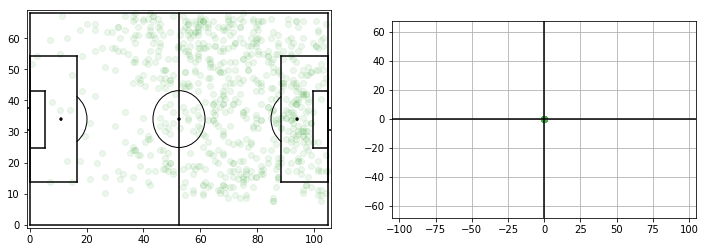

['x', 'y', 'dx', 'type_cross_a0', 'type_corner_crossed_a0', 'type_corner_short_a0', 'type_shot_a0']


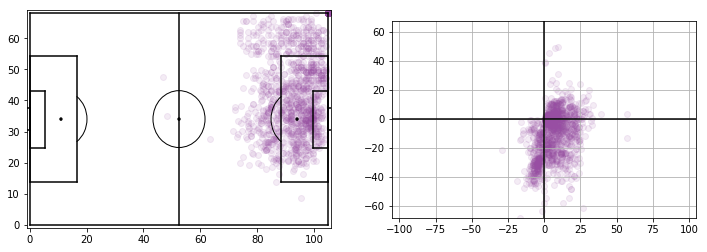

['x', 'y', 'type_take_on_a0']


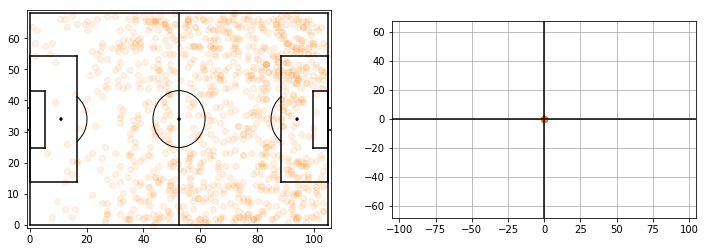

['x', 'dx', 'dy', 'type_throw_in_a0']


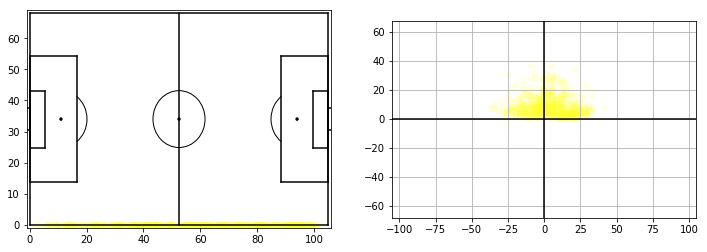

['x', 'y', 'dx', 'dy', 'type_clearance_a0']


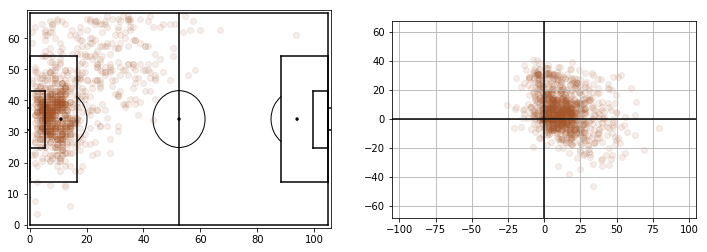

['x', 'y', 'type_receival_a0']


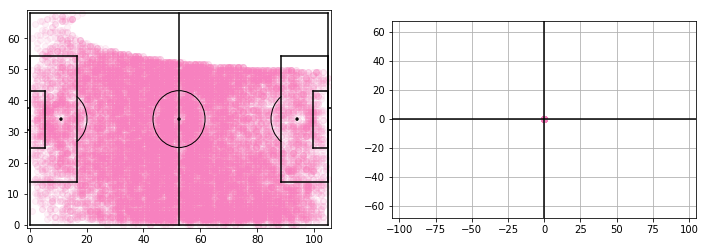

['x', 'y', 'dx', 'type_dribble_a0']


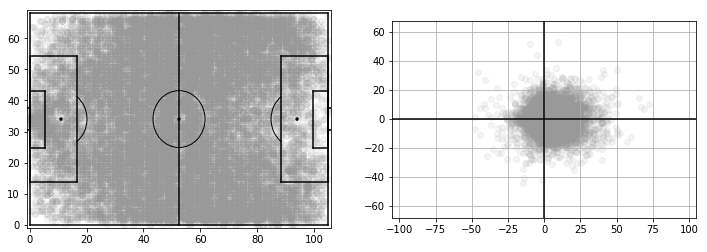

['x', 'y', 'dx', 'type_clearance_a0']


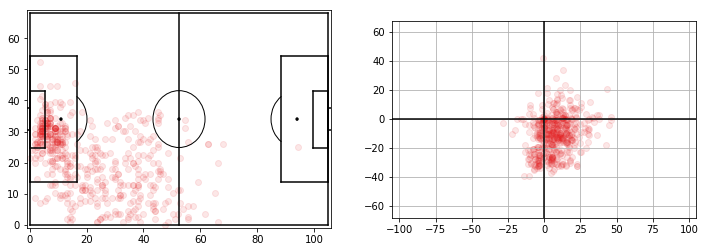

CPU times: user 8min 15s, sys: 4min 47s, total: 13min 2s
Wall time: 2min 40s


In [39]:
%%time
import sklearn.cluster as clus
import sklearn.mixture as mix
import socceraction.atomic.features as fs

a = actions[:100000].copy()

#a = actions[actions.type_name == "pass"][:40000].copy()
a = a.fillna(0)
#a = actions[:100000].copy()
print(len(a))
di = fs.direction(a)
#a["dx"] = di.dx_a0
#a["dy"] = di.dy_a0
a[atoh]= fs.actiontype_onehot(a).applymap(int)
nbc = 28

cols = ["x","y", "dx","dy"] + atoh

# gmm = mix.GaussianMixture(nbc,verbose=2).fit(a[["x","y",
#                                       "dx","dy",
#                                      ]])
gmm = mix.GaussianMixture(nbc,verbose=2).fit(a[cols])
#color_clusters([(x,y) for (x,y,dx,dy) in gmm.means_],colors)
#print(clustercolors)
labels = gmm.predict(a[cols])
#                      [["x","y",
#                         "dx","dy",
#                        ]])

plot_deltas(a.x,a.y,a.dx,a.dy,color=[clustercolors[l] for l in labels])
for l in set(labels):
    l_idx = labels == l
    m = [cols[i] for i, v in enumerate(gmm.means_[l]) if v > 0.01]
    print(list(m))
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=clustercolors[l])

In [59]:
cols = ["x","y", "dx","dy"]

models = {}
bics = {}
a = actions[:100000].copy().fillna(0)
for type_name, df in a.groupby("type_name"):
    if len(df) > 10:
        print(type_name,len(df))
        typemodels = list([mix.GaussianMixture(nbc).fit(df[cols]) for nbc in range(1,11)])
        typebics = list([m.bic(df[cols]) for m in typemodels])
        models[type_name] = typemodels
        bics[type_name] = typebics

bad_touch 810
clearance 1519
corner_crossed 276
corner_short 67
cross 703
dribble 28544
foul 719
freekick_crossed 333
freekick_short 321
goal 87
goalkick 477
interception 5932
keeper_claim 109
keeper_punch 26
keeper_save 185
offside 18
out 640
pass 28637
receival 26172
shot 813
shot_freekick 23
tackle 1139
take_on 1021
throw_in 1343
yellow_card 73


bad_touch
clearance
corner_crossed
corner_short
cross
dribble
foul
freekick_crossed
freekick_short
goal
goalkick
interception
keeper_claim
keeper_punch
keeper_save
offside
out
pass
receival
shot
shot_freekick
tackle
take_on
throw_in
yellow_card


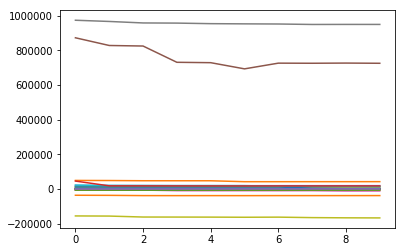

[(-162516.1915142636, 'receival'),
 (-38452.45182550786, 'interception'),
 (-10822.144445894273, 'out'),
 (-6805.350780133959, 'tackle'),
 (-5966.875768046955, 'take_on'),
 (-4743.5483299723965, 'bad_touch'),
 (-4153.173515891293, 'foul'),
 (-2761.1178238338102, 'corner_crossed'),
 (-2708.838214466093, 'keeper_save'),
 (-1840.105537095745, 'goal'),
 (-1071.902296285084, 'keeper_claim'),
 (-362.7052226961423, 'corner_short'),
 (-217.98195850259233, 'keeper_punch'),
 (-208.19372016131115, 'yellow_card'),
 (-26.854392995879635, 'offside'),
 (520.8244714371864, 'shot_freekick'),
 (10865.574433210566, 'freekick_short'),
 (11202.15054202995, 'freekick_crossed'),
 (11216.87312484022, 'goalkick'),
 (17518.480239948847, 'throw_in'),
 (18946.00642343701, 'cross'),
 (19357.040524441694, 'shot'),
 (47291.98975242965, 'clearance'),
 (728725.9263185667, 'dribble'),
 (953876.5395224964, 'pass')]

In [62]:
bicdiff = [((v[4]),k) for k,v in bics.items()]
for k,v in bics.items():
    print(k)
    plt.plot(v)
    #plt.show()
plt.show()
sorted(list(bicdiff))

In [25]:
states = gmm.predict_proba(actions[["x","y"]])
states.shape

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1188669 but corresponding boolean dimension is 1188670

In [184]:
actions = actions.fillna(0)
nex_actions = actions.shift(-1)
valid_idx = (actions.team_id == nex_actions.team_id) & (actions.period_id == nex_actions.period_id)
print(sum(valid_idx)/ len(valid_idx))
prev = gmm.predict_proba(actions[valid_idx][["x","y","dx","dy"]])
nex = gmm.predict_proba(nex_actions[valid_idx][["x","y","dx","dy"]])
prev,nex

0.8807810409953982


(array([[0.   , 0.   , 0.   , ..., 0.   , 0.004, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.   , 0.006, 0.   ]]),
 array([[0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.128, 0.054, 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.001, 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.004, 0.   , 0.157],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
        [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ]]))

(50, 1046958)


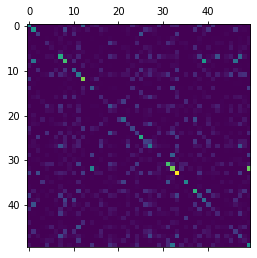

(0.9999999999999999, 1046958.0000000005)

In [222]:
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)
print(prev.T.shape)
trans = np.dot(prev.T,nex)
trans /= trans.sum()
#for i in range(len(trans)):
    #p(trans[:,i].sum())
plt.matshow(trans)
plt.show()
#trans = np.dot(trans.T,trans)
trans.sum(),prev.sum()

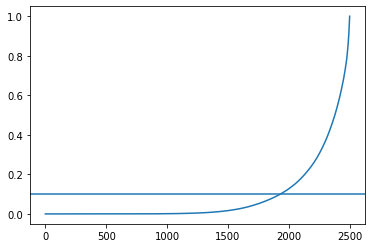

In [226]:
plt.plot(np.cumsum(sorted(trans.flatten())))
plt.axhline(0.1)
plt.show()

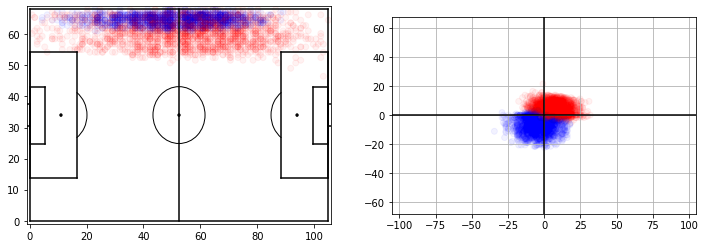

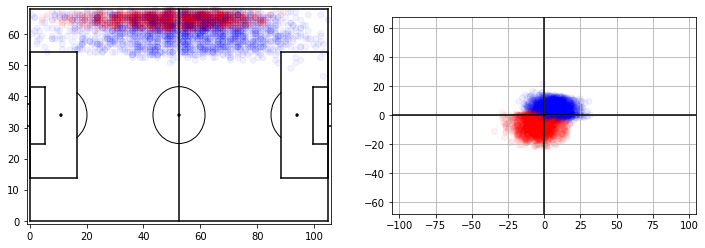

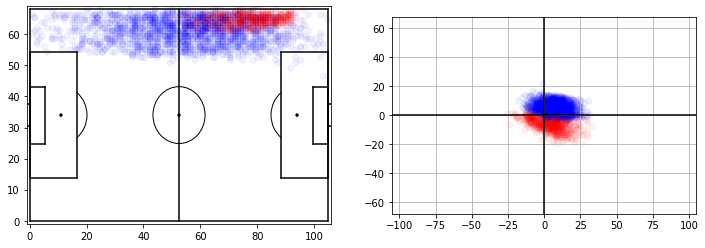

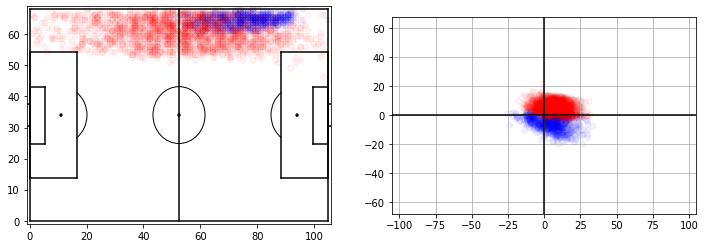

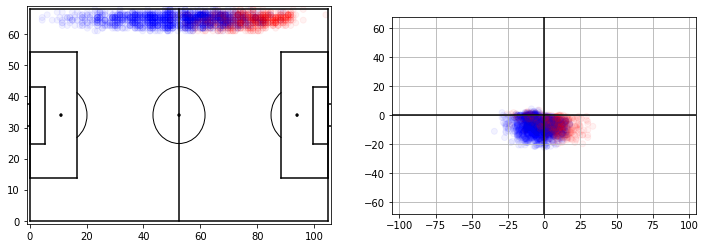

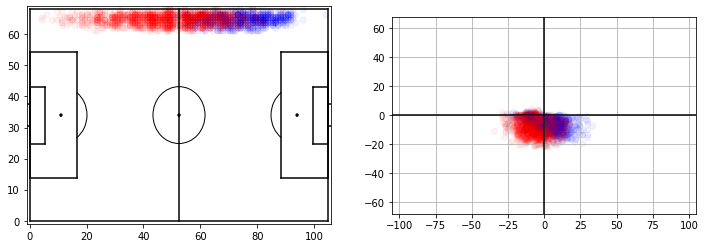

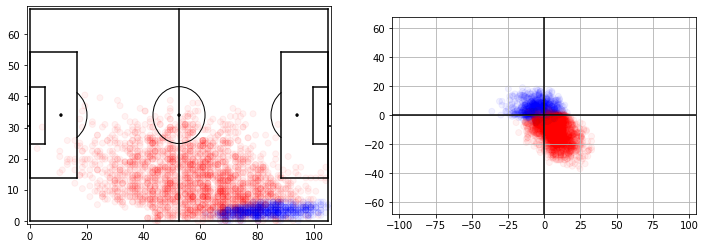

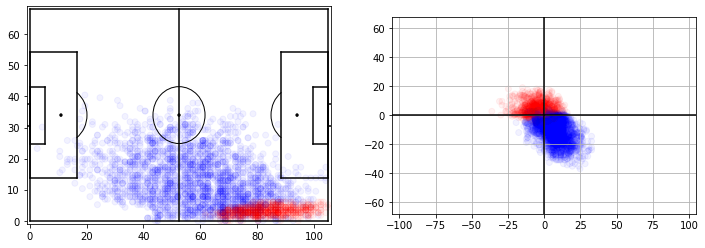

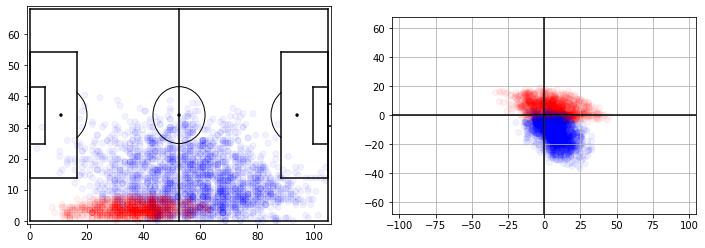

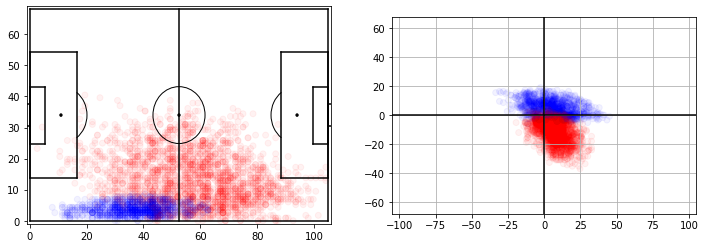

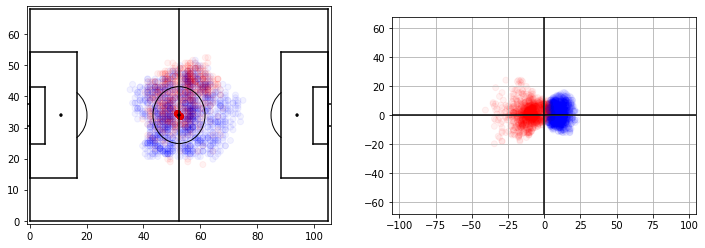

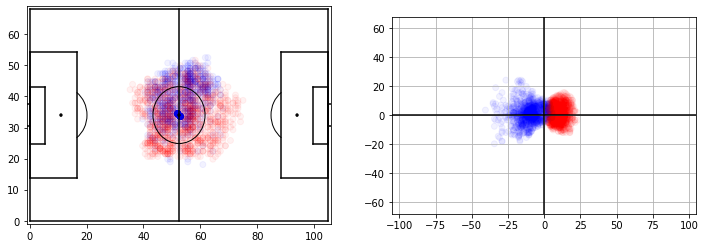

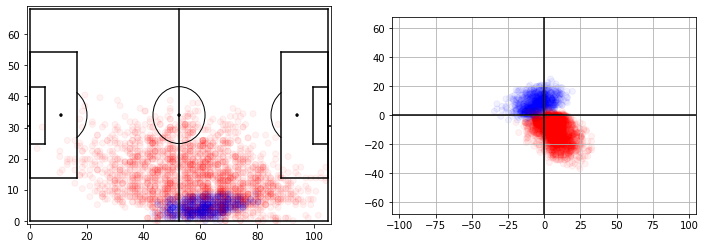

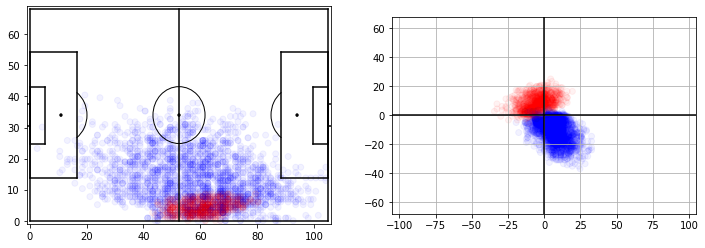

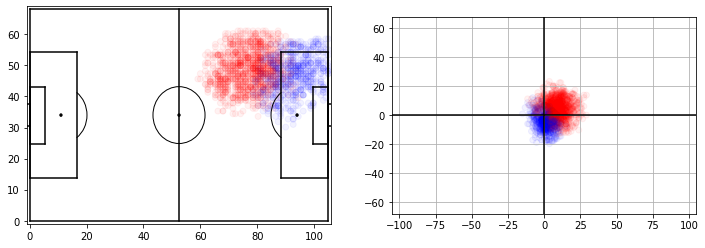

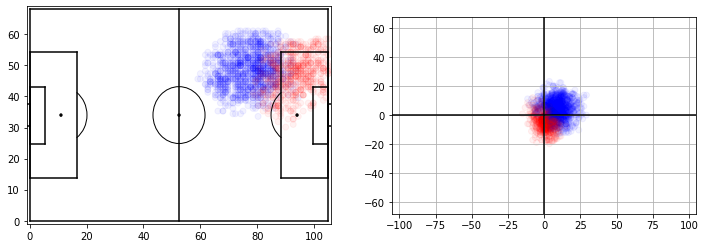

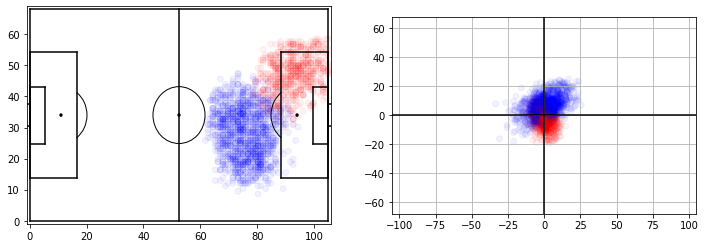

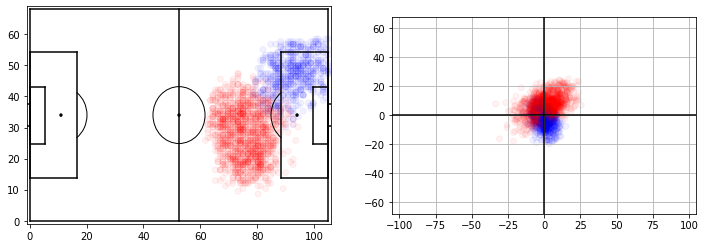

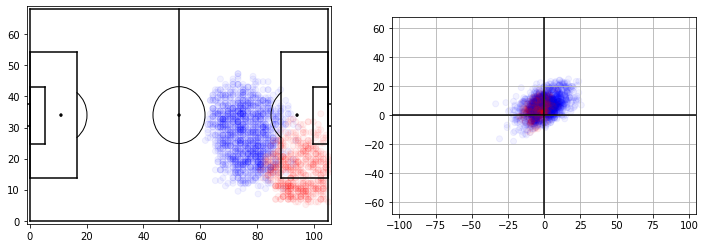

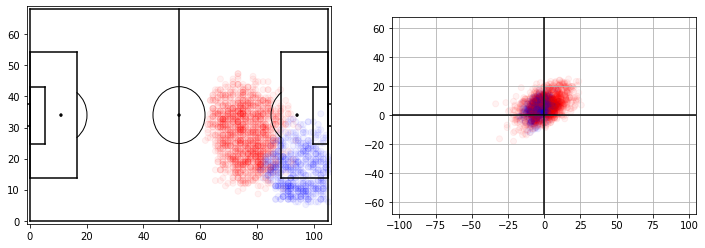

In [186]:
probs = []
for i in range(nbc):
    for j in range(nbc):
        probs.append((trans[i,j],i,j))
probs = sorted(probs,reverse=True)
movs = [(p,i,j) for p,i,j in probs if i != j]
for p,i,j in movs[:20]:
    l_idx = (labels == i) | (labels == j)
    twocolors = ["blue" if l == i else "red" for l in labels[l_idx]]
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=twocolors)

Text(0.5, 0, 'n_components')

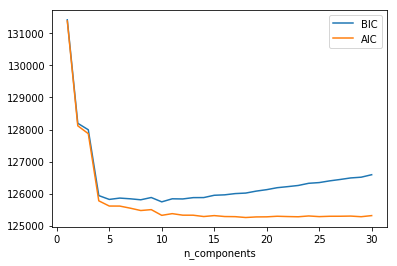

In [136]:
n_components = np.arange(1, 31)
models = [mix.GaussianMixture(n).fit(a[["x","y"]])
          for n in n_components]

plt.plot(n_components, [m.bic(a[["x","y"]]) for m in models], label='BIC')
plt.plot(n_components, [m.aic(a[["x","y"]]) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

100%|██████████| 370/370 [00:00<00:00, 459.07it/s]


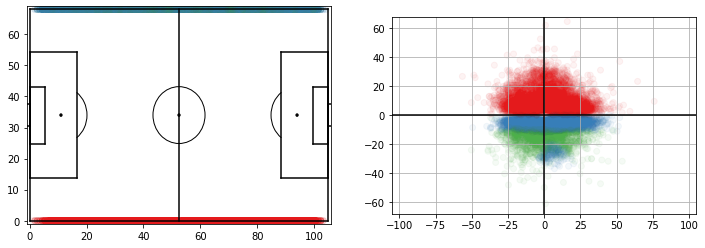

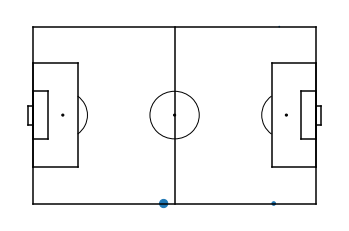

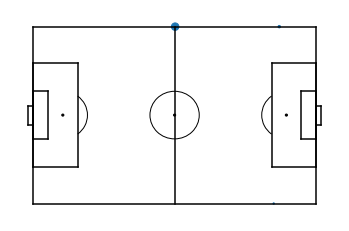

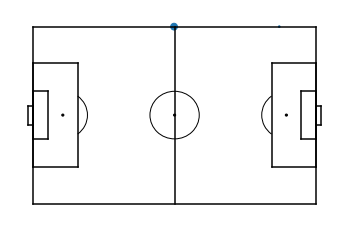

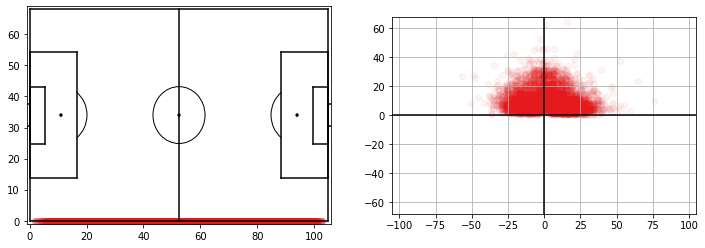

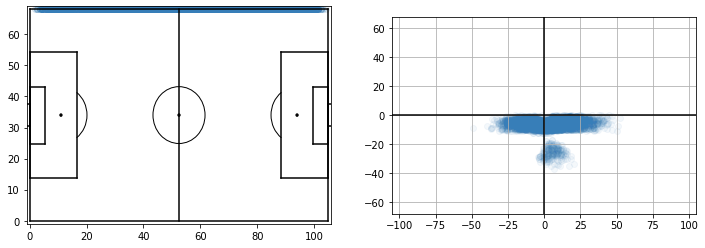

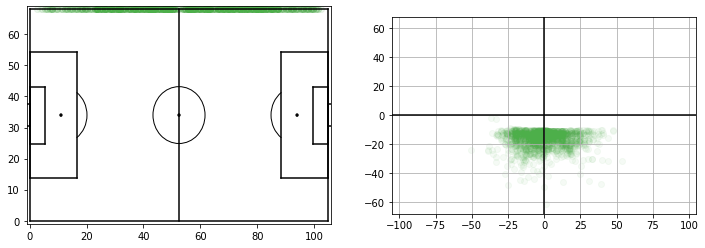

In [201]:
import numpy

nbp = len(set(a.player_id))
vectors = np.zeros((nbp,nbc))

player_ids = []
for i,(player_id,df) in tqdm.tqdm(list(enumerate(a.groupby(["player_id"])))):
    probs = gmm.predict_proba(df[["x","y"
                                  ,"dx","dy"
                                 ]])
    playervector = probs.mean(axis=0)
    player_ids.append(player_id)
    vectors[i,:] = playervector
#vectors


from sklearn.decomposition import NMF
model = NMF(3).fit(vectors)
from sklearn.decomposition import LatentDirichletAllocation as LDA
#model = LDA(6).fit(vectors)
model.components_

components = []
for c in model.components_:
    components.append(c/c.sum())
#model.components_ = np.array(components)
model.components_ = model.components_ / np.linalg.norm(model.components_)

#print(model.components_ )

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

# ax = mps.field(show=False)
# for component in model.components_:
#     c_idx = component > 0.1
    
#     ax.scatter(x,y,s=100*component,alpha=0.5)
#     #plt.show()
# plt.show()    

def predict_cluster(points,gmm,nmf):
    gaussprobs = gmm.predict_proba(points)
    clusterscores = nmf.transform(gaussprobs)
    return np.argmax(clusterscores,axis=1)

points = a[["x","y",
            "dx","dy",
           ]].values
clusterlabels = predict_cluster(points,gmm,model)

#ax = mps.field(show=False)
plot_deltas(a.x,a.y,a.dx,a.dy,[list(colors*10)[l] for l in clusterlabels])
#ax.scatter(x,y,color=[colors[l] for l in clusterlabels])
#plt.show()

x = np.array([cc[0] for cc in gmm.means_])
y = np.array([cc[1] for cc in gmm.means_])

for component in model.components_:
    c_idx = component > 0.1
    ax = mps.field(show=False)
    ax.scatter(x,y,s=100*component,alpha=1)
    plt.show()

for l in set(clusterlabels):
    l_idx = clusterlabels == l
    plot_deltas(a.x[l_idx],a.y[l_idx],a.dx[l_idx],a.dy[l_idx],color=(colors * 10)[l])

(array([ 842., 2767., 9516., 9579., 6379., 4105., 2657., 1363., 1491.,
        1301.]),
 array([0.366, 0.623, 0.88 , 1.138, 1.395, 1.652, 1.909, 2.167, 2.424,
        2.681, 2.938]),
 <a list of 10 Patch objects>)

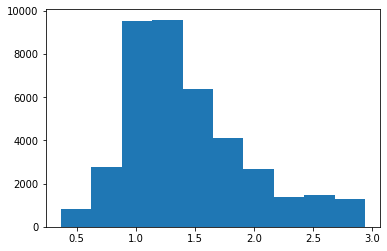

In [194]:
gaussprobs = gmm.predict_proba(points)
clusterscores = model.transform(gaussprobs)
plt.hist(clusterscores.sum(axis=1))

In [107]:
#plt.scatter(range(len(clusterscores[0])),clusterscores.sum(axis=1))
#plt.show()
#plt.hist(clusterscores.sum(axis=1))
#model.components_.sum(axis=1)


array([3137.044,  657.396, 3112.793, 3291.776, 2240.714])